In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates

In [102]:
folder_path = 'C:\\Users\\linti\\Desktop\\Advanced Data Science for Transport and Engineering\\Weekly_Data'
data_sensors_path = '\\0922_Sensor_data_Bucharest.csv'
path = folder_path + data_sensors_path
data_sensors = pd.read_csv(path, delimiter=',')

In [103]:
data_sensors

,date,status,sensor id,location name,city name
0,2024-10-10 05:11:34+00:00,True,863213040205978,Veteranilor,Bucharest
1,2024-10-10 06:33:08+00:00,True,863213040219615,Veteranilor,Bucharest
2,2024-10-10 06:33:24+00:00,False,863213040219615,Veteranilor,Bucharest
3,2024-10-10 06:50:57+00:00,False,863213040204880,Veteranilor,Bucharest
4,2024-10-10 06:55:46+00:00,True,863213040219615,Veteranilor,Bucharest
...,...,...,...,...,...
54941,2025-09-22 13:11:12+00:00,True,863213040215126,Veteranilor,Bucharest
54942,2025-09-22 13:11:24+00:00,True,863213040198850,Cernișoara,Bucharest
54943,2025-09-22 13:11:50+00:00,False,863213040198850,Cernișoara,Bucharest
54944,2025-09-22 13:12:15+00:00,True,863213040219615,Veteranilor,Bucharest


Create columns named "date" in YY-MM-DD, "time" in hh:mm:ss, and day in 0-6 where 0 denotes Monday and 6 denotes Sunday.

In [104]:
# Convert Timestamp column to datetime
data_sensors['date'] = pd.to_datetime(data_sensors['date'], errors='coerce', utc=True)
# print(data_sensors)
data_sensors['day'] = data_sensors['date'].dt.dayofweek

Create filters

In [105]:
def filter_by_location(data, loc):
    return data[data["location name"] == loc]
def filter_by_date(data, start_date, end_date): # can be multiple date gaps
    '''
    start_date, end_date should be 'YYYY-MM-DD' strings or datetime
    '''
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    return data[(data["date"].dt.date >= start_date.date()) &
                (data["date"].dt.date <= end_date.date())]

Custom ur filter here

In [106]:
def filter_by_masks(df):
    mask = False
    # Mon–Fri: 06–18
    mask |= ((df["day"].between(0, 4)) &
             (df["date"].dt.hour >= 6) &
             (df["date"].dt.hour < 18))

    # Sat: 06–16
    mask |= ((df["day"] == 5) &
             (df["date"].dt.hour >= 6) &
             (df["date"].dt.hour < 16))

    # Sun: three slots
    # 05:30–08:30
    mask |= ((df["day"] == 6) &
             ((df["date"].dt.hour == 5) & (df["date"].dt.minute >= 30) |
              (df["date"].dt.hour > 5) & (df["date"].dt.hour < 8) |
              (df["date"].dt.hour == 8) & (df["date"].dt.minute < 30)))

    # 12:00–14:00
    mask |= ((df["day"] == 6) &
             (df["date"].dt.hour >= 12) &
             (df["date"].dt.hour < 14))

    # 18:30–20:00
    mask |= ((df["day"] == 6) &
             ((df["date"].dt.hour == 18) & (df["date"].dt.minute >= 30) |
              (df["date"].dt.hour == 19) |
              (df["date"].dt.hour == 20) & (df["date"].dt.minute == 0)))

    return df[mask]

In [ ]:
df_loc = filter_by_location(data_sensors, "Piața Orizont")
df_date = filter_by_date(df_loc, start_date="2025-09-20", end_date="2025-09-20")
df_time = filter_by_masks(df_date)

3. Pick sensors in the location

In [108]:
def get_sensors(data):
    """Assumes 'sensor' column exists with sensor IDs/names"""
    return data["sensor id"].unique()

In [109]:
sensors = get_sensors(df_loc) # should be 2 sensors in the Piața Orizont

4. Plot one sensor's status over time

In [110]:
def plot_sensor(data, sensor_name, fig, ax, i, j = 0):
    sensor_data = data[data["sensor id"] == sensor_name]
    ax.step(sensor_data["date"], sensor_data["status"].astype(int))
    # Major ticks every hour
    fig.gca().xaxis.set_major_locator(mdates.HourLocator())
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Minor ticks every 15 minutes
    fig.gca().xaxis.set_minor_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
    # Show grid for both major and minor ticks
    ax.grid(which='major', linestyle='-', linewidth=0.8)
    ax.grid(which='minor', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_title(f"Sensor: {sensor_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Status (1=True, 0=False)")
    ax.grid(True, alpha=0.3)
    # Save only the area of this Axes
    # fig.savefig(f"single_subplot{i}{j}.png", dpi = 200)

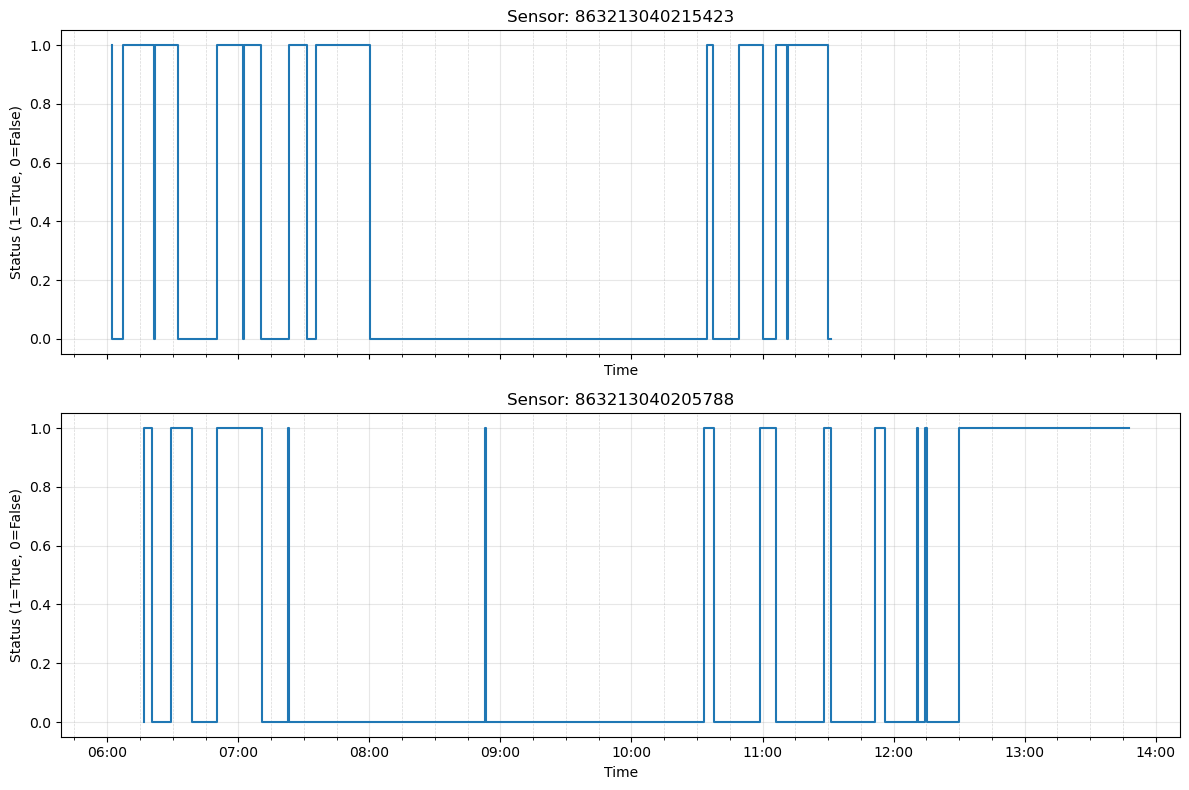

In [111]:
fig, axes = plt.subplots(len(sensors), 1, figsize=(12, 4*len(sensors)), sharex=True)
# Handle case where only one sensor (axes not iterable)
if len(sensors) == 1:
    axes = [axes]

for i, sensor in enumerate(sensors):
    plot_sensor(df_time, sensor, fig, ax=axes[i], i = i)

plt.tight_layout()
plt.show()

Divide days by repeatedly calling the function filter_by_date and draw a plot with a single day. The rows of the subplot are the sensors. The columns of the subplot are the days. Each subplot shows the status of a single sensor on a single day, using your existing plotting style (step plot, hourly major ticks, 15-min minor ticks, etc.)

In [112]:
start_date = '2025-09-15'
end_date = '2025-09-22'
days = pd.date_range(start=start_date, end=end_date, freq='D') # a list of days between end_date and start_date
fig, axes = plt.subplots(len(sensors), len(days), figsize=(4*len(days), 3*len(sensors)), sharex=True)

# Handle case where only one sensor (axes not iterable)
if len(sensors) == 1:
    axes = [axes]
for j, day in enumerate(days):
    df_date = filter_by_date(df_loc, start_date = day, end_date = day)
    df_time = filter_by_masks(df_date)
    for i, sensor in enumerate(sensors):
        plot_sensor(df_time, sensor, fig, ax=axes[i][j], i, j)

plt.tight_layout()
plt.show()

SyntaxError: positional argument follows keyword argument (4261084157.py, line 13)